# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook - good example how to add TabPFN
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric - good guide on creating custom metric in Keras
- https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/410139 - overall notes about similar competitions

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )
- [x] CV TabPFN - looks even inferior to GBT. May be due to preprosessing.
- [x] Ensembled into Submition results from several Classifiers (There is aa room for Playing with manually assigned weights)
- [x] Due to time consideration -> SUBMITION: bool
- [x] Submition Error When calculating results.
- [x] Rethink CV (check dimension) v31->v32,
- [x] Solve problem with accuracy (showns NaNs) -> Changed to Binary Accuracy version
- [x] Solved problem with NaNs in metric -> min/max vals less than 1 more than 0, as in competrion calculator
- [x] loss: 0.0000e+00. Why ? Is it OK ? -> Yes it is okey. https://discuss.tensorflow.org/t/tfdf-custom-loss/2223
- [ ] Research wheather it is possible to train with respect to Gradient of the metric.
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [ ] Ensemble Results by some model:
    - Currently Simple Manual Weights, which may be more optimal. Need to make some grid and choose the best.
    - I use Mean for Each CV Branch, may-be also grant some threshs or weights
    - [x] Refactored each Model Estimation to result into Train/Valid/Test Frames
- [ ] Cutoffs
    - https://medium.com/swlh/determining-a-cut-off-or-threshold-when-working-with-a-binary-dependent-target-variable-7c2342cf2a7c
    - Find Lower/Upper Bounds which maximises competition metric
- [ ] May be try several CVs
- [ ] May be play with uplift to lessen features input
    

In [1]:
SUBMITION = False

## Install TabPFN offline

In [2]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [3]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [25]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

import joblib
import os
import shutil

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the Dataset

In [5]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [8]:
mining_columns: list = [i for i in dataset_df.columns if i not in ["Id","Class"]]

def compute_basic_stats(columns: list, df: pd.DataFrame) -> pd.DataFrame:
    
    out: dict = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

# Train
basic_stats_1 = compute_basic_stats(columns=mining_columns, df=dataset_df)

# Inference
basic_stats_1.to_pickle('/kaggle/working/basic_stats_1.pickle')

  0%|          | 0/56 [00:00<?, ?it/s]

In [9]:
basic_stats_1

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU,253,0.2,float64,0.26,0.005518,161.355315,9.034721,1.8029,5.55868
BC,259,0.0,float64,0.16,1.2299,1463.693448,65.166943,8.053012,5.724924
AF,599,0.0,float64,0.3,192.59328,28688.18766,2300.322717,3502.013221,5.900177
EH,127,0.0,float64,0.18,0.003042,42.569748,1.847499,0.305107,5.900177
AM,605,0.0,float64,0.24,3.177522,630.51823,69.728226,38.968552,5.900177
FD,337,0.0,float64,0.13,0.29685,1578.654237,64.754262,6.930086,5.900177
DI,571,0.0,float64,0.26,60.23247,1049.168078,86.084419,146.972099,5.900177
FR,435,0.0,float64,0.1,0.49706,1244.22702,50.181948,3.533905,5.900177
AB,217,0.0,float64,0.28,0.081187,6.161666,0.468388,0.477149,6.017012
CF,586,0.0,float64,0.11,0.510888,200.967526,13.571133,11.241064,6.192265


* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [10]:
WoE_Columns = ['DU', 'BC', 'AF', 'EH', 'AM', 'FD', 'DI', 'FR', 'AB', 'CF', 'BZ', 'FE', 'AX', 'BR',
               'GB', 'AY', 'FC', 'FS', 'CC', 'GH', 'DV', 'DY', 'EE', 'GE', 'AH', 'DN', 'EP', 'EU',
               'EG', 'FI', 'DH', 'GF', 'GI', 'DE', 'DA', 'CW', 'CU', 'AZ', 'CL', 'CH', 'BD', 'BN',
               'DL', 'CS', 'FL', 'GL', 'CB', 'DF', 'BP', 'EB', 'AR', 'CD', 'EL', 'CR', 'BQ']

In [11]:
def preprocess_train(train: pd.DataFrame, numeric_features: list, save_path: str) -> None:
    woes = dict()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train[i], y=train['Class'])
        woes[i] = tmp_woe
    
    # Save WoE
    _ = joblib.dump(value=woes, filename=save_path)
    print('Saved features: ', save_path)
    
    return None

def preprocess_inference(train: pd.DataFrame, test: pd.DataFrame, 
                         numeric_features: list,
                         stats: pd.DataFrame, save_path: str) -> (pd.DataFrame, pd.DataFrame, list):
    info = dict()
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    woes = joblib.load(save_path)
    
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        train_out[i + '_WoE'] = woes[i].transform(X=train_out[i])
        test_out[i + '_WoE'] = woes[i].transform(X=test_out[i])
        out_features.append(i + '_WoE')
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features


# Only for Train
_ = preprocess_train(train=dataset_df, numeric_features=WoE_Columns, save_path='/kaggle/working/WoE.pickle')

# For Train & Inference
train_out,test_out,features = preprocess_inference(train=dataset_df, test=dataset_test_df,
                                               stats=basic_stats_1, numeric_features=WoE_Columns,
                                              save_path='/kaggle/working/WoE.pickle')

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Saved features:  /kaggle/working/WoE.pickle


WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

##### Fold 1
Use /tmp/tmpysgv_zf5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.943482. Found 308 examples.
Training model...
Model trained in 0:00:00.458622
Compiling model...


[INFO 23-07-28 20:58:50.9168 UTC kernel.cc:1242] Loading model from path /tmp/tmpysgv_zf5/model/ with prefix 744e8f18cad24fa8
[INFO 23-07-28 20:58:51.0067 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 25702 node(s), and 113 input feature(s).
[INFO 23-07-28 20:58:51.0068 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-28 20:58:51.0068 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 379ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3693


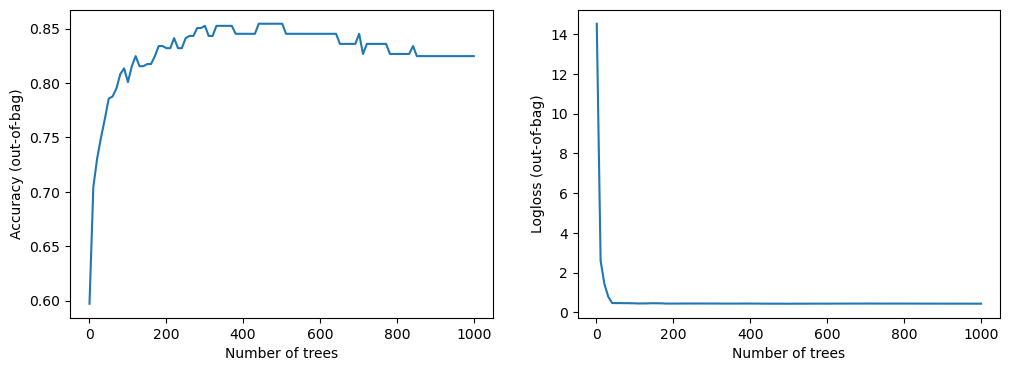


Train: 0.1899 Validation: 0.3693
##### Fold 2
Use /tmp/tmp0kf8zs6p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.822191. Found 309 examples.
Training model...
Model trained in 0:00:00.446655
Compiling model...


[INFO 23-07-28 20:58:57.0739 UTC kernel.cc:1242] Loading model from path /tmp/tmp0kf8zs6p/model/ with prefix 6e6ddaa116fd46c9
[INFO 23-07-28 20:58:57.1608 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 25796 node(s), and 113 input feature(s).
[INFO 23-07-28 20:58:57.1609 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 382ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9188 - balanced_log_loss: 0.4127


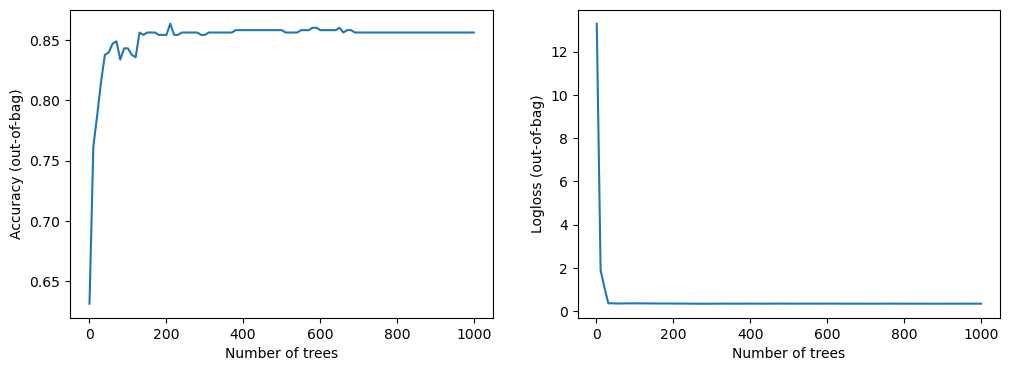


Train: 0.5218 Validation: 0.4127

Train mean: 0.3559 std: 0.2347

Validation mean: 0.3910 std: 0.0307


In [67]:
class BalancedLogLoss(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_log_loss', **kwargs):
        super(BalancedLogLoss, self).__init__(name=name, **kwargs)
        self.log_loss = self.add_weight(name='log_loss', initializer='zeros')

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Correct Values
        min_val = 1e-15
        max_val = 0.999999999999999
        
        y_pred = tf.math.minimum(y_pred, [max_val])
        y_pred = tf.math.maximum(y_pred, [min_val])
        
        log_y_pred_1 = tf.reshape(K.log(y_pred),[-1,1])
        log_y_pred_0 = tf.reshape(K.log(1-y_pred),[-1,1])

        y_1 = tf.reshape(y_true,[1,-1])
        y_0 = 1-y_1

        logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
        logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

        av_logloss = (logloss_1+logloss_0)/2
        
        self.log_loss.assign_add(av_logloss)

    def result(self):
        return self.log_loss

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.log_loss.assign(0.)

def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()


from sklearn.base import BaseEstimator 
from sklearn.base import RegressorMixin
    
class TFDF_CV_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, model_obj = tfdf.keras.RandomForestModel, label = "Class"):
        self.label: str = label
        self.model_obj = model_obj
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.valid_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list()
        self.models: dict = dict()
        self.metrics: dict = dict()
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, features: list, splitter = StratifiedKFold(),
            model_kwargs = dict(), model_compile_kwargs = dict()):

        n_splits = splitter.get_n_splits()

        # Create a various frames
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan), index=X.index) # For In-Sample Predictions of each Fold
        self.valid_summary = pd.DataFrame(data=np.full((len(X.index),1), np.nan), index=X.index) # For Out-of-Sample Prediction of each Fold
        self.features: list = features
        
        # Create an empty dictionary to store the models Xed for each fold.
        self.models = {}
        self.metrics = {}
        balanced_logloss_train = {}
        balanced_logloss_val = {}

        class_weight: dict = self._compute_weights(X)
        
        for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X['Class'])):
                print('##### Fold',i+1)

                # Fetch values corresponding to the index 
                train_df = X.iloc[train_index]
                valid_df = X.iloc[valid_index]
                valid_ids = valid_df.index.values
                train_ids = train_df.index.values

                # Select only feature columns for training.
                train_df = train_df[self.features+[self.label]]
                valid_df = valid_df[self.features+[self.label]]

                # We need to convert the datatset from Pandas format (pd.DataFrame)
                train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=self.label)
                valid_tf = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=self.label)

                # Define & Train the model and metrics
                model = self.model_obj(**model_kwargs)
                model.compile(**model_compile_kwargs) 
                model.fit(x=train_tf, class_weight=class_weight)

                # Store the model
                self.models[i] = model

                # Predict Values
                self.X_summary.loc[train_ids, i] = model.predict(x=train_tf).flatten()
                self.valid_summary.loc[valid_ids, 0] = model.predict(x=valid_tf).flatten()

                # Evaluate and store the metrics in respective dicts
                evaluation = model.evaluate(x=train_tf,return_dict=True)
                train_metric = evaluation["balanced_log_loss"]

                evaluation = model.evaluate(x=valid_tf,return_dict=True)
                val_metric = evaluation["balanced_log_loss"]

                # Plot Results
                plot_train_logs(model)

                balanced_logloss_train[i] = train_metric
                balanced_logloss_val[i] = val_metric

                print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")

        self.metrics['train'] = balanced_logloss_train
        self.metrics['val'] = balanced_logloss_val

        print(f"\nTrain mean: {pd.Series(self.metrics['train']).mean():.4f} std: {pd.Series(self.metrics['train']).std():.4f}")
        print(f"\nValidation mean: {pd.Series(self.metrics['val']).mean():.4f} std: {pd.Series(self.metrics['val']).std():.4f}")
        
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        
        X_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X) # Technial, to conert frame to tensor for makind a predictions using tensor framework
        X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan),index=X.index) # For X (Sumbition) Predictions of each Fold's Model

        for i, model in enumerate(self.models.values()):
            X_summary[i] = model.predict(x=X_tf).flatten() 
        
        return X_summary
    
    def save(self, save_path: str) -> None:
        try:
            shutil.rmtree(save_path)
        except FileNotFoundError:
            pass
        else:
            pass
            
        os.makedirs(f'{save_path}/models', exist_ok=True)
        
        for fold, model in self.models.items():
            # model.save(filepath=f'{save_path}/models/{fold}')
            joblib.dump(value=model, filename=f'{save_path}/models/{fold}.pickle')
        
        # TODO: Other attributes
        joblib.dump(value=self.label, filename=f'{save_path}/label.pickle')
        joblib.dump(value=self.model_obj, filename=f'{save_path}/model_obj.pickle')
        
        joblib.dump(value=self.X_summary, filename=f'{save_path}/X_summary.pickle')
        joblib.dump(value=self.valid_summary, filename=f'{save_path}/valid_summary.pickle')
        joblib.dump(value=self.features, filename=f'{save_path}/features.pickle')
        joblib.dump(value=self.metrics, filename=f'{save_path}/metrics.pickle')
            
        return None
    
    def load(self, save_path: str):
        
        # TODO: Other attributes
        self.label = joblib.load(filename=f'{save_path}/label.pickle')
        self.model_obj = joblib.load(filename=f'{save_path}/model_obj.pickle')
        
        self.X_summary = joblib.load(filename=f'{save_path}/X_summary.pickle')
        self.valid_summary = joblib.load(filename=f'{save_path}/valid_summary.pickle')
        self.features = joblib.load(filename=f'{save_path}/features.pickle')
        self.metrics = joblib.load(filename=f'{save_path}/metrics.pickle')
        
        self.models = dict()
        
        for name in os.listdir(f'{save_path}/models'):
            i = name.split('.')[0]
            self.models[int(i)] = joblib.load(filename=f'{save_path}/models/{name}')
            
        return self
    

# Test
my_splitter = StratifiedKFold(n_splits=2,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_1 = CV_Ensemble_1.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_1.save(save_path='/kaggle/working/RF/1')

# # RandomForestModel
# if not SUBMITION:
#     train_summary_rf_1, valid_summary_rf_1, test_summary_rf_1, model_rf_1,metrics_rf_1 = train_model(
#         train=train_out,test=test_out, features=features,
#         splitter=my_splitter,
#         model_obj=tfdf.keras.RandomForestModel,
#         model_kwargs=dict(max_depth=6, num_trees=1000),
#         model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]),
#         save_path = '/kaggle/working/RF/1'
#     )

In [68]:
# load
CV_Ensemble_1_load = TFDF_CV_Ensemble()

CV_Ensemble_1_load = CV_Ensemble_1_load.load(save_path='/kaggle/working/RF/1')

Use /tmp/tmplvaeo3k_ as temporary training directory
Use /tmp/tmp5mllem1f as temporary training directory


In [69]:
CV_Ensemble_1_load.models

{0: <tensorflow_decision_forests.keras.RandomForestModel at 0x7f12c2a5a290>,
 1: <tensorflow_decision_forests.keras.RandomForestModel at 0x7f13dd5a53c0>}

In [73]:
# Let's try to find Cutoffs organically
train_summary_rf_1_mean = train_summary_rf_1.mean(axis=1)
train_summary_rf_1_mean.name = 'Pred'

tmp = pd.concat([train_summary_rf_1_mean, train_out['Class']], axis=1).sort_index(ascending=True)

tmp['Pred_Bins'] = pd.qcut(x=tmp['Pred'],q=100)
tmp = tmp.groupby('Pred_Bins')['Class'].agg({'sum','count'})
tmp['count_cumsum'] = tmp['count'].cumsum()
tmp['sum_cumsum'] = tmp['sum'].cumsum()

tmp['bads_rate'] = tmp['sum_cumsum']/tmp['count_cumsum']

tmp['perc_sum'] = [*range(1,101)]

tmp


,count,sum,count_cumsum,sum_cumsum,bads_rate,perc_sum
Pred_Bins,,,,,,
"(0.0006000000000000001, 0.00706]",7,0,7,0,0.000000,1
"(0.00706, 0.00979]",6,0,13,0,0.000000,2
"(0.00979, 0.0128]",6,0,19,0,0.000000,3
"(0.0128, 0.0153]",6,0,25,0,0.000000,4
"(0.0153, 0.0175]",6,0,31,0,0.000000,5
"(0.0175, 0.0186]",6,0,37,0,0.000000,6
"(0.0186, 0.0206]",7,0,44,0,0.000000,7
"(0.0206, 0.0236]",6,0,50,0,0.000000,8
"(0.0236, 0.0259]",6,0,56,0,0.000000,9


# RandomForestModel

In [ ]:
# RandomForestModel
if not SUBMITION:
    train_summary_rf_1, valid_summary_rf_1, test_summary_rf_1, model_rf_1,metrics_rf_1 = train_model(
        train=train_out,test=test_out, features=features,
        n_splits=6,
        model_obj=tfdf.keras.RandomForestModel,
        model_kwargs=dict(max_depth=6, num_trees=1000),
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

In [ ]:
# RandomForestModel
if not SUBMITION:
    train_summary_rf_2, valid_summary_rf_2, test_summary_rf_2, model_rf_2,metrics_rf_2 = train_model(
        train=train_out,test=test_out, features=features,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.RandomForestModel,           
        model_kwargs=dict(max_depth=6, num_trees=300),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

In [ ]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

In [ ]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# GradientBoostedTreesModel

In [ ]:
# GradientBoostedTreesModel

if not SUBMITION:

    features_slice = [i for i in features if len(i) > 2]

    train_summary_gbt_1, valid_summary_gbt_1, test_summary_gbt_1, model_gbt_1,metrics_gbt_1 = train_model(
        train=train_out,test=test_out, features=features_slice,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.GradientBoostedTreesModel,            
        model_kwargs=dict(max_depth=5, num_trees=1000),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

In [ ]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

train_summary_gbt_2, valid_summary_gbt_2, test_summary_gbt_2, model_gbt_2,metrics_gbt_2 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

# TabPFN

In [ ]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    
    # Correct Values
    min_val = 1e-15
    max_val = 0.999999999999999

    y_pred = np.minimum(y_pred, [max_val])
    y_pred = np.maximum(y_pred, [min_val])
    
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

def train_model_tabpfn_one(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    test_summary = pd.DataFrame(data=np.full((len(test.index),1), np.nan),index=test.index)
    train_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_test = model.predict_proba(test[features])[:,1]

    # Predict value for validation/Submition data
    test_summary[0] = p_test.flatten() 
    train_summary[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
    metrics['balanced_logloss'] = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    print(f"\nTrain: {metrics['balanced_logloss']:.4f}")
    
            
    return train_summary, test_summary, model, metrics


def train_model_tabpfn_cv(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6) -> (pd.DataFrame, dict,  dict):

    # Create a various frames
    train_summary = pd.DataFrame(data=np.full((len(train.index),n_splits), np.nan), index=train.index) # For In-Sample Predictions of each Fold
    
    valid_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan), index=train.index) # For Out-of-Sample Prediction of each Fold
    
    test_summary = pd.DataFrame(data=np.full((len(test.index),n_splits), np.nan),index=test.index) # For Test (Sumbition) Predictions of each Fold's Model
    

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            train_ids = train_df.index.values
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # Define & Train the model
            model = TabPFNClassifier(N_ensemble_configurations=64)
            model.fit(train_df[features],train_df[label])

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            p_train = model.predict_proba(train_df[features])[:,1]
            p_val = model.predict_proba(valid_df[features])[:,1]
            p_sub = model.predict_proba(test[features])[:,1]
            
            # Predict Values
            train_summary.loc[train_ids, i] = p_train
            valid_summary.loc[valid_ids, 0] = p_val
            test_summary[i] = p_sub

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[label].values,y_pred=p_val)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
            
    return train_summary, valid_summary, test_summary, models,metrics

In [ ]:
# TabPFN tabpfn_
if not SUBMITION:
    features_slice = [i for i in features if len(i) > 2]
    train_summary_tabpfn_1, test_summary_tabpfn_1, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
        train=train_out,test=test_out, features=features_slice)

In [ ]:
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,test=test_out, features=features_slice, n_splits=6)

# Ensemble CV

In [ ]:
class EnsembleCV(object):
    def __init__(self):
        self.is_fitted = False
        self.weights = None
        return
    
    def fit(self, X: pd.DataFrame) -> None:
        self.weights = None
        return
    
    @staticmethod
    def predict(X: pd.DataFrame) -> pd.Series:
        # Take conservative estimate
        X_ = X.mean(axis=1) #.to_frame()
        # Fillna by 1
        X_ = X_.fillna(1)
        return X_

In [ ]:
rf_ensemble = EnsembleCV()
gbt_ensemble = EnsembleCV()
tabpfn_ensemble = EnsembleCV()

test_rf_ensemble = rf_ensemble.predict(X=test_summary_rf_3)
test_gbt_ensemble = gbt_ensemble.predict(X=test_summary_gbt_2)
test_tabpfn_ensemble = tabpfn_ensemble.predict(X=test_summary_tabpfn_1)

In [ ]:
train_out['Class_RF'] = rf_ensemble.predict(X=train_summary_rf_3)
test_out['Class_RF'] = rf_ensemble.predict(X=test_summary_rf_3)

print(pd.Series(metrics_rf_3['train']).mean())
print(pd.Series(metrics_rf_3['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_RF'].values))

In [ ]:
train_out['Class_GBT'] = gbt_ensemble.predict(X=train_summary_gbt_2)
test_out['Class_GBT'] = gbt_ensemble.predict(X=test_summary_gbt_2)

print(pd.Series(metrics_gbt_2['train']).mean())
print(pd.Series(metrics_gbt_2['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_GBT'].values))

In [ ]:
train_out['Class_TABPFN'] = tabpfn_ensemble.predict(X=train_summary_tabpfn_1)
test_out['Class_TABPFN'] = tabpfn_ensemble.predict(X=test_summary_tabpfn_1)

print(pd.Series(metrics_tabpfn_2['train']).mean())
print(pd.Series(metrics_tabpfn_2['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_TABPFN'].values))

# Ensemble Classes

I can for example use GBT

In [ ]:
train_out[['Class_RF','Class_GBT','Class_TABPFN','Class']].corr()

In [ ]:
# GradientBoostedTreesModel
# Got Very Bas score up to 1.5 in LB
# train_summary_gbt_3, valid_summary_gbt_3, test_summary_gbt_3, model_gbt_3,metrics_gbt_3 = train_model(
#     train=train_out,test=test_out, features=['Class_RF','Class_GBT','Class_TABPFN'],                                             
#     n_splits=10,                    
#     model_obj=tfdf.keras.GradientBoostedTreesModel,            
#     model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
#     model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

In [ ]:
RF_w = 2.5/10
GBT_w = 4.5/10
TabPFN_w = 3./10

print('RF weight: ', RF_w)
print('GBT weight: ', GBT_w)
print('TabPFN weight: ', TabPFN_w)

submition_total = test_out[['Class_RF','Class_GBT','Class_TABPFN']].copy()
submition_total.columns = ['RF','GBT','TabPFN']

submition_total['Ensemble'] = RF_w*submition_total['RF'] + GBT_w*submition_total['GBT'] + TabPFN_w*submition_total['TabPFN']

submition_total.head()

# Submission

In [ ]:
# submition_total
submition_total['Ensemble'] = np.where(submition_total['Ensemble']>0.95,1,submition_total['Ensemble'])
submition_total['Ensemble'] = np.where(submition_total['Ensemble']<0.05,0,submition_total['Ensemble'])
submition_total['class_1'] = submition_total['Ensemble']
submition_total['class_0'] = 1 - submition_total['class_1']
submition_total = submition_total[['class_0','class_1']].copy()
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

In [ ]:
submition_total.head()

In [ ]:
submition_total.info()